In [1]:
########## Calling relevant libraries ##########
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy

# Setting matplotlib options for this notebook
import matplotlib
from matplotlib import pyplot as plt

import sklearn
from sklearn.externals import joblib



/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# load neuravi
import neuravi

### Load dataset

ds = neuravi.data_loader("./data/DataSet_0p20val.hdf5",
                         "./data/NKAS_Raman.hdf5",
                         "./data/NKAS_density.hdf5",
                         "./data/NKAS_optical.hdf5","cpu")

/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [7]:
X_ = ds.x_entro_train.detach().numpy()
y_ = ds.y_entro_train.detach().numpy()

In [25]:
import gplearn as gp
from gplearn.genetic import SymbolicRegressor
est_gp = SymbolicRegressor(function_set=('add', 'sub', 'mul', 'div', 'log'),
                           population_size=5000,
                           generations=20, stopping_criteria=0.001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_, y_)

/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    21.18          43.4461       14          3.28547          4.00974     33.36s
   1    19.59          11.9504       29          1.32974           1.5583     34.03s
   2    26.38          12.2825       37          1.33284          1.61835     37.83s
   3    24.86          13.2822       33          1.21818          1.20165     36.40s
   4    26.00           17.562       29          1.18661          1.20106     32.46s
   5    24.95          15.5657       27          1.13174          1.27921     28.88s
   6    21.99          13.6361       35          1.10052         0.912463     24.91s
   7    20.22          10.2142       35          1.06975          1.18939     24.24s
   8    20.28          7.52967       37          1.03263          1.10821  

SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
                  function_set=('add', 'sub', 'mul', 'div', 'log'),
                  generations=20, init_depth=(2, 6),
                  init_method='half and half', low_memory=False,
                  max_samples=0.9, metric='mean absolute error', n_jobs=1,
                  p_crossover=0.7, p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_point_replace=0.05, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.001, tournament_size=20,
                  verbose=1, warm_start=False)

In [26]:
X_test = ds.x_entro_test.detach().numpy()
y_test = ds.y_entro_test.detach().numpy()

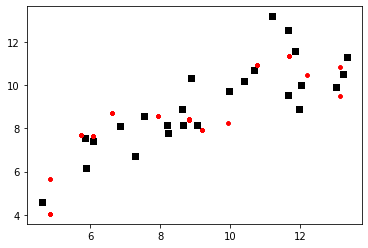

In [27]:
plt.plot(y_, est_gp.predict(X_),"ks")
plt.plot(y_test,  est_gp.predict(X_test),"r.")

<ErrorbarContainer object of 3 artists>

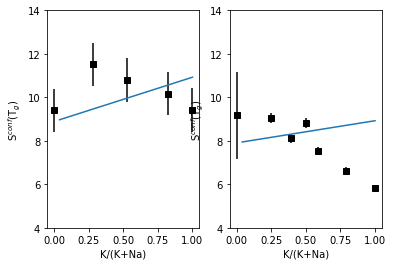

In [28]:
na2o = np.arange(0.,0.25,0.01)
k2o = 0.25-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.zeros(len(na2o))

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.subplot(1,2,1)
plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),est_gp.predict(X_visu_),label="NN model")

plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.28,0.53,0.82,1.0]),np.array([32.91,40.31,37.81,35.59,32.99])/7.0*2.0,
    yerr = 1.0, fmt="ks",
    label="Richet, 1984")

plt.subplot(1,2,2)
na2o = np.arange(0.,0.125,0.01)
k2o = 0.125-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.ones(len(na2o))*0.125

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),est_gp.predict(X_visu_),label="NN model")

plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.25,0.39,0.50,0.59,0.79,1.00]),
             np.array([9.17,9.06,8.12,8.84,7.54,6.63,5.83]),
    yerr = np.array([2.,0.23,0.20,0.23,0.18,0.15,0.11]), fmt="ks",
    label="Le Losq et al., 2017")

In [24]:
est_gp.warm_start = True
est_gp.stopping_criteria=0.001
est_gp.fit(X_, y_)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/gplearn/genetic.py:435: UserWarning: Warm-start fitting without increasing n_estimators does not fit new programs.
  warn('Warm-start fitting without increasing n_estimators does not '


SymbolicRegressor(const_range=(-1.0, 1.0), feature_names=None,
                  function_set=('add', 'sub', 'mul', 'div', 'log'),
                  generations=20, init_depth=(2, 6),
                  init_method='half and half', low_memory=False,
                  max_samples=0.9, metric='mean absolute error', n_jobs=1,
                  p_crossover=0.7, p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_point_replace=0.05, p_subtree_mutation=0.1,
                  parsimony_coefficient=0.01, population_size=5000,
                  random_state=0, stopping_criteria=0.001, tournament_size=20,
                  verbose=1, warm_start=True)